In [36]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
mpl.style.available
mpl.style.use('ggplot') 
from IPython.display import display, HTML
from itertools import cycle, islice
from matplotlib.font_manager import FontProperties
from ipywidgets import widgets
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from bokeh.plotting import figure, output_file, show
import datetime as dt 
from IPython.display import clear_output

from patsy import dmatrices
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.feature_selection import RFE

## Customer demographic data initial exploration

In [2]:
## read customer demographic data
customers_df = pd.read_table("customer/000000_0",
                             header=None,
                             names = ['customer_id','churn_label',
                                      'gender','country','date_created',
                                      'YOB','premier'])
##convet churn label to 0 and 1
customers_df["churn_label"] = customers_df["churn_label"] - 1

##convert date_created to datetime object
customers_df["date_created"] = pd.to_datetime(customers_df["date_created"])

##convert year of birth to datetime object
customers_df["YOB"] = pd.to_datetime(customers_df["YOB"],format='%Y')

##insert account age in days, most recent order in receipts data is 30/3/2014
latest_date = dt.date(2014,3,30)
customers_df["account_age"] = (latest_date - customers_df["date_created"]).dt.days

##insert account age in months, better for plotting
latest_date = dt.date(2014,3,30)
customers_df["account_age_months"] = np.ceil((latest_date - customers_df["date_created"]).dt.days/30)

##insert customer age in years
customers_df["customer_age"] = np.floor((latest_date - customers_df["YOB"]).dt.days/365)

In [3]:
customers_df.head()

,customer_id,churn_label,gender,country,date_created,YOB,premier,account_age,account_age_months,customer_age
0,1852043,1,F,UK,2005-03-02 19:35:50,1986-01-01,0,3314,111.0,28.0
1,1825138,0,F,UK,2005-11-25 20:32:39,1981-01-01,0,3046,102.0,33.0
2,863960,0,M,UK,2005-05-12 13:04:19,1983-01-01,0,3243,109.0,31.0
3,585725,0,F,UK,2006-03-23 16:59:31,1976-01-01,6,2928,98.0,38.0
4,1773666,1,F,UK,2006-04-20 18:42:44,1990-01-01,0,2900,97.0,24.0


## Churned customers have shorter account age on average

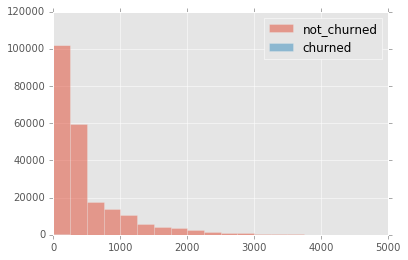

Average account age for not churned is: 486.83522621154583
Average account age for churned is: nan


In [4]:
x = customers_df[(customers_df.churn_label == 1) 
             & (customers_df.account_age < 6000)]["account_age"]

y = customers_df[(customers_df.churn_label == 2) 
             & (customers_df.account_age < 6000)]["account_age"]

plt.hist(x, alpha=0.5, label='not_churned',bins=20)
plt.hist(y, alpha=0.5, label='churned',bins=20)
plt.legend(loc='best')
plt.show()
print('Average account age for not churned is:',x.mean())
print('Average account age for churned is:',y.mean())

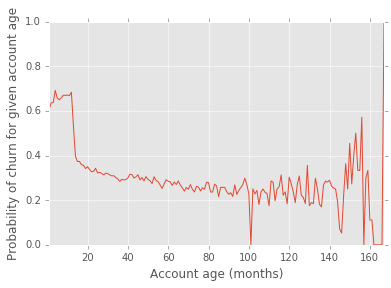

In [5]:
customers_df[(customers_df.account_age_months < 200)].groupby("account_age_months")["churn_label"].mean().plot()

plt.xlabel("Account age (months)")
plt.ylabel("Probability of churn for given account age")

## Massive decrease in churn once account is over 12 months old, is this just an artifact of the way churn is defined?

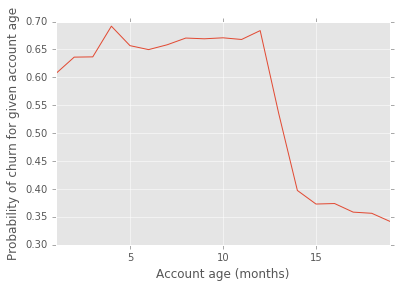

In [6]:
customers_df[(customers_df.account_age_months < 20)].groupby("account_age_months")["churn_label"].mean().plot()

plt.xlabel("Account age (months)")
plt.ylabel("Probability of churn for given account age")

## A higher proportion of teenage and older customers churn

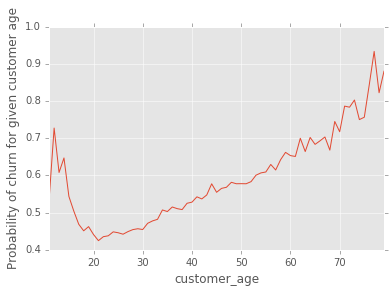

In [7]:
customers_df[(customers_df.customer_age < 80)
             & (customers_df.customer_age > 10)].groupby("customer_age")["churn_label"].mean().plot()

plt.ylabel("Customer age (years)")
plt.ylabel("Probability of churn for given customer age")

## Gender doesn't seem to affect churn

In [8]:
print("Proportion of female customers",len(customers_df[customers_df.gender == "F"])/len(customers_df))

print("Probability churn given female",len(customers_df[(customers_df.churn_label == 1) 
             & (customers_df.gender == "F")])/len(customers_df[(customers_df.gender == "F")]))

print("Probability churn given male",len(customers_df[(customers_df.churn_label == 1) 
             & (customers_df.gender == "M")])/len(customers_df[(customers_df.gender == "M")]))
            

Proportion of female customers 0.7565534945944968
Probability churn given female 0.4734220203087926
Probability churn given male 0.49346065472082196


In [9]:
def time_elapsed_since_last_order(row,customer_orders):
    '''
    Parameters
    ----------
    row:
        Row of dataframe

    customer_orders: 
        customer order summary dataframe

    Returns
    -------
    time_elapsed_since_last_order:
        the amount of time in days since the customer
        last made an order
    '''
    
    latest_date = dt.datetime(2014,4,30)
    
    ## find their most recent order
    
    most_recent = customer_orders["signal_datetime"].iloc[0]
    
    time_elapsed = latest_date - most_recent
    
    return time_elapsed.days

In [10]:
#read all receipt files
dfs_to_concat = []

for i in range(0,3):                                                            
    dfs_to_concat.append(
        pd.read_table("receipts/00000%d_0" % i,header=None,names = ['customer_id','product_id',
                                                            'source_id','division_id','item_qty',
                                                            'signal_datetime','receipt_id','price']))
receipts_df = pd.concat(dfs_to_concat)

#convert signal date to datetime object
receipts_df["signal_datetime"] = pd.to_datetime(receipts_df["signal_datetime"])
receipts_df["date"] = receipts_df["signal_datetime"].dt.date

##create order summary dataframe, 
##this contains the number of items bought and the total value of the order

##group all orders (groupby columns are not aggregated) and sum over item_qty and price

order_sum_df = receipts_df.groupby(
    ['receipt_id','signal_datetime','customer_id']).sum().reset_index()

##drop product_id, source_id, division_id as they are now meaningless
order_sum_df.drop(['product_id','source_id', 'division_id'], axis = 1, inplace = True)

order_sum_df["date"] = order_sum_df["signal_datetime"].dt.date

##create a dataframe that is a summary of all of a customers orders
customer_order_sum_df = receipts_df.groupby('customer_id').sum().reset_index()

#columns are now meaningless
customer_order_sum_df.drop(
    ['product_id','source_id', 'division_id','receipt_id'], axis = 1, inplace = True)

#round up price to make groupby plots more intelligible
customer_order_sum_df["rounded_price"] = np.rint(customer_order_sum_df["price"])


#merge with customer_df
customer_order_sum_df = pd.merge(
    customer_order_sum_df,customers_df,on="customer_id")

latest_date = dt.datetime(2014,4,30)

#create time elapsed since last order feature
last_order_df = pd.DataFrame(receipts_df.groupby("customer_id")["signal_datetime"].max()).reset_index()

last_order_df.rename(columns={'signal_datetime': 'last_order_datetime'}, inplace=True)

last_order_df["time_elapsed_since_last"] = (latest_date - last_order_df["last_order_datetime"]).dt.days

customer_order_sum_df = pd.merge(
    customer_order_sum_df,last_order_df[["customer_id","time_elapsed_since_last"]],on="customer_id")

#add number of orders a customer has made
num_of_orders = pd.DataFrame(order_sum_df.groupby(["customer_id"])["receipt_id"].count()).reset_index()

num_of_orders.columns = ["customer_id","no_of_orders"]

customer_order_sum_df = pd.merge(
    customer_order_sum_df,num_of_orders[["customer_id","no_of_orders"]],on="customer_id")

## Probability of churn decreases with number of items bought

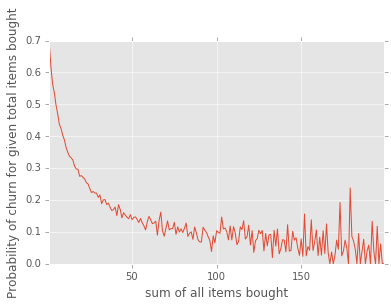

In [11]:
customer_order_sum_df[customer_order_sum_df.item_qty < 200].groupby("item_qty")["churn_label"].mean().plot()

plt.xlabel("sum of all items bought")
plt.ylabel("Probability of churn for given total items bought")

In [12]:
order_sum_df.head()

,receipt_id,signal_datetime,customer_id,item_qty,price,date
0,26679889,2011-01-01 00:08:17.943,1260484,2,34.0,2011-01-01
1,26679929,2011-01-01 00:13:58.613,1429891,4,48.0,2011-01-01
2,26679935,2011-01-01 00:14:39.487,1874262,7,87.0,2011-01-01
3,26679980,2011-01-01 00:20:03.847,1034616,2,22.0,2011-01-01
4,26679994,2011-01-01 00:21:37.230,1107672,5,114.0,2011-01-01


## Probability of churn decreases with total number of orders

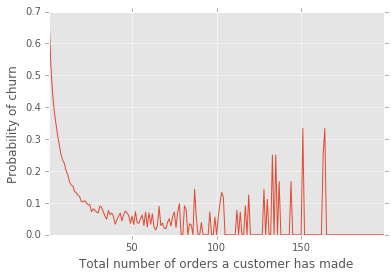

In [13]:
customer_order_sum_df[customer_order_sum_df.no_of_orders < 200].groupby("no_of_orders")["churn_label"].mean().plot()

plt.xlabel("Total number of orders a customer has made")
plt.ylabel("Probability of churn")

## Probability of churn decreases with total spend

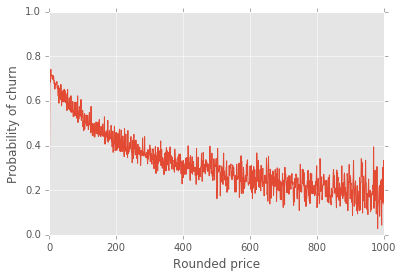

In [14]:
customer_order_sum_df[customer_order_sum_df.price < 1000].groupby("rounded_price")["churn_label"].mean().plot()

plt.xlabel("Rounded price")
plt.ylabel("Probability of churn")

## Again churn drops dramatically after around a year, could be an artefact

Technically the customers who haven't ordered anything for a year should have already been classed as churned..

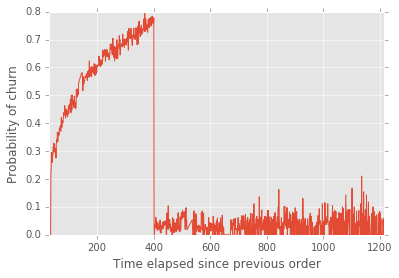

In [15]:
customer_order_sum_df.groupby("time_elapsed_since_last")["churn_label"].mean().plot()

plt.xlabel("Time elapsed since previous order")
plt.ylabel("Probability of churn")

In [ ]:
y, X = dmatrices('churn_label ~ item_qty + price \
                    + C(premier) + account_age + customer_age\
                    + no_of_orders + time_elapsed_since_last',
                  customer_order_sum_df, return_type="dataframe")


scaler = StandardScaler()
X = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.2)
    
clf = KNeighborsClassifier()


clf.fit(X_train,y_train)

print(clf.score(X_test,y_test))


#print(clf.feature_importances_)
# create the RFE model and select 3 attributes
rfe = RFE(clf,3)
rfe = rfe.fit(X_train,y_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)